In [1]:
import cv2
import os
import pafy
import math
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import *
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping
import random


2024-10-02 19:00:27.538356: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 19:00:27.543385: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-02 19:00:27.554989: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 19:00:27.576721: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 19:00:27.585036: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 19:00:27.610561: I tensorflow/core/platform/cpu_feature_gu

In [2]:
seedConstant = 27
np.random.seed(seedConstant)
random.seed(seedConstant)
tf.random.set_seed(seedConstant)


## download Data set https://www.crcv.ucf.edu/data/UCF50.rar

### for unZip the folder

unrar x UCF50.rar


[41, 30, 44, 17, 18, 12, 4, 43, 16, 34, 21, 49, 23, 25, 11, 15, 40, 31, 42, 37]


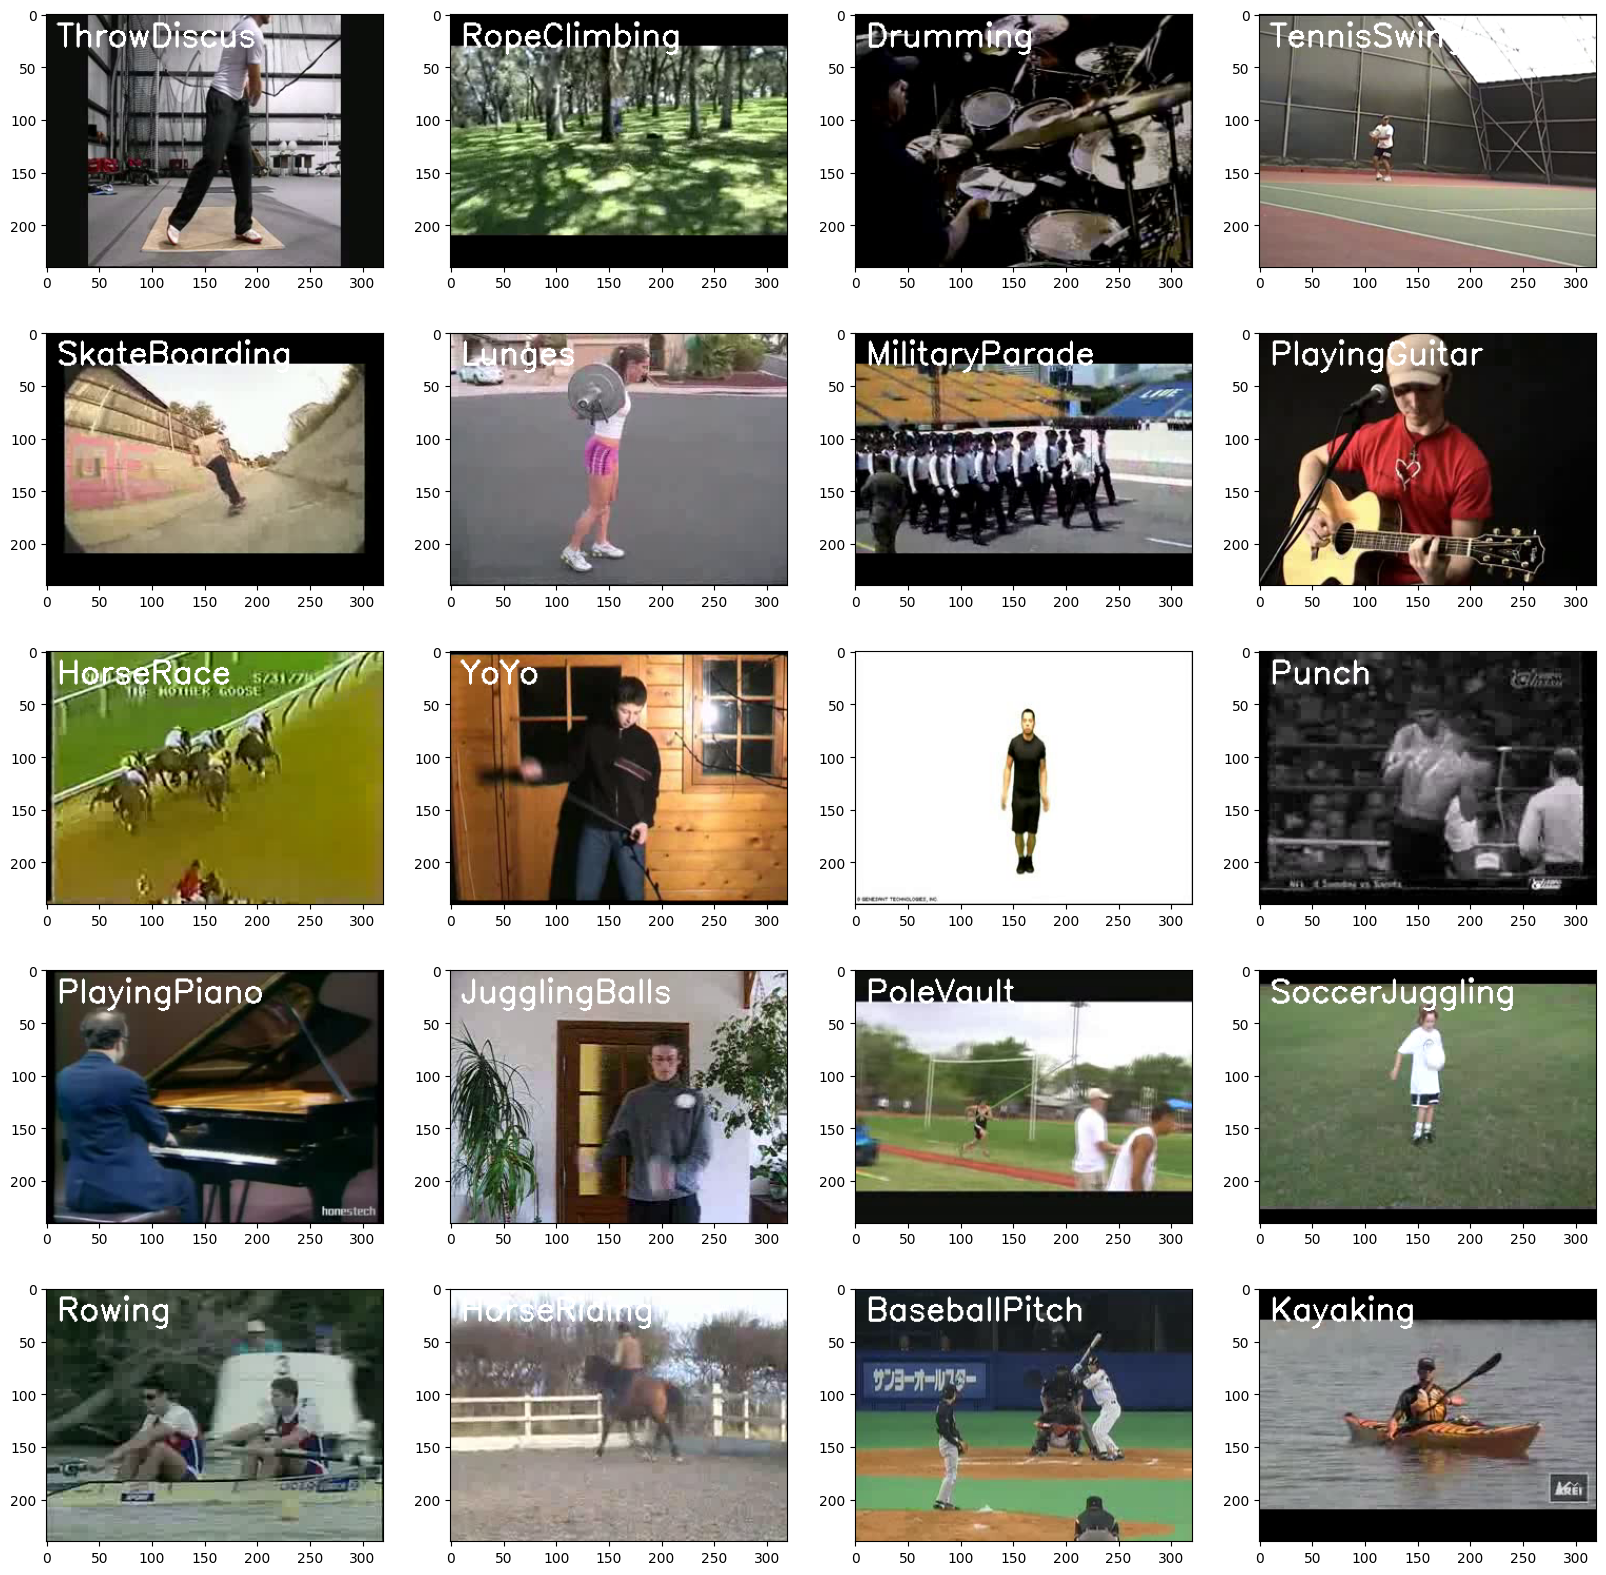

In [3]:
plt.figure(figsize=(20,20))

allClassesNames = os.listdir("UCF50/")
randomRange = random.sample(range(len(allClassesNames)),20)
print(randomRange)
for counter,idx in enumerate(randomRange,1):
    selectedClassName = allClassesNames[idx]
    
    videoFilesNamesList = os.listdir(f"UCF50/{selectedClassName}")
    
    selectedVideoFileName = random.choice(videoFilesNamesList)
    
    videoReader = cv2.VideoCapture(f"UCF50/{selectedClassName}/{selectedVideoFileName}")
    
    _,frame =  videoReader.read()
    videoReader.release()
    
    rgbFrame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    
    cv2.putText(rgbFrame,selectedClassName,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
    
    plt.subplot(5,4,counter)
    plt.imshow(rgbFrame)


In [3]:
imageSize = (64,64)

sequenceLength = 20

DataSetDir = "UCF50/"

classNames = ["WalkingWithDog","TaiChi","Swing","HorseRace"]


In [10]:
def framesExtract(videoPath):
    
    framesList = []
    
    cap = cv2.VideoCapture(videoPath)
    
    frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    skipFramesWindow = max(int(frameCount/sequenceLength),1)
    
    for frameCounter in range(sequenceLength):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameCounter*skipFramesWindow)
        ret, frame = cap.read()
        if ret:
            resizedFrame = cv2.resize(frame,imageSize)
            normalizedFrame = resizedFrame / 255.0
            framesList.append(normalizedFrame)
        
    cap.release()
    return framesList


In [11]:
def createDataSet():
    features = []
    labels = []
    videoFilesPath = []
    for classIdx, className in enumerate(classNames):
        print(f"extract data from : {className}")
        filesList = os.listdir(os.path.join(DataSetDir,className))
        for fileName in  filesList:
            videoFilePath = os.path.join(DataSetDir,className,fileName)
            frames = framesExtract(videoFilePath)
            if  len(frames) ==  sequenceLength:
                features.append(frames)
                videoFilesPath.append(videoFilePath)
                labels.append(classIdx)
    features = np.array(features)
    labels = np.array(labels)
    return features ,labels ,videoFilesPath


In [ ]:
features ,labels ,videoFilesPath= createDataSet()
len(features)


In [13]:
labels = to_categorical(labels, num_classes=len(classNames))  


In [14]:
xTrain,xTest,yTrain,yTest = train_test_split(features,labels,random_state=seedConstant,shuffle=True,test_size=0.25)


In [19]:
def createConvLstmModel():
    model = Sequential([
        ConvLSTM2D(4, (3, 3), activation='tanh', data_format="channels_last", recurrent_dropout=0.2, return_sequences=True, input_shape=(sequenceLength, 64, 64, 3)),
        MaxPooling3D((1, 2, 2), data_format="channels_last"),
        TimeDistributed(Dropout(0.2)),
        ConvLSTM2D(8, (3, 3), activation='tanh', data_format="channels_last", return_sequences=True),
        MaxPooling3D((1, 2, 2), data_format="channels_last"),
        TimeDistributed(Dropout(0.2)),
        ConvLSTM2D(16, (3, 3), activation='tanh', data_format="channels_last", return_sequences=True),
        MaxPooling3D((1, 2, 2), data_format="channels_last"),
        TimeDistributed(Dropout(0.2)),
        ConvLSTM2D(32, (3, 3), activation='tanh', data_format="channels_last"),
        TimeDistributed(Dropout(0.2)),
        Flatten(),
        Dense(len(classNames), activation="softmax")
    ])
    model.summary()
    return model


In [ ]:
model = createConvLstmModel()


In [ ]:
plot_model(model,show_shapes=True,show_layer_names=True,to_file="model.png")



In [ ]:
model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=['accuracy'])
model.fit(features,labels,epochs=20,shuffle=True,validation_split=0.2)


In [ ]:
model.evaluate(xTest,yTest)
model.save("new.h5")


In [4]:
import keras
modelNew = keras.saving.load_model("./new.h5")


I0000 00:00:1727884851.976770   61352 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-02 19:00:51.977557: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
modelLoss , modelAccuracy = modelNew.evaluate(xTest,yTest)


In [53]:
def createLRCN():
    model =  Sequential([
        TimeDistributed(Conv2D(16,(3,3),activation='relu',input_shape=(sequenceLength,64,64,3))),
        TimeDistributed(MaxPooling2D((2,2))),
        TimeDistributed(Dropout(0.25)),
        TimeDistributed(Conv2D(32,(3,3),activation='relu',input_shape=(sequenceLength,64,64,3))),
        TimeDistributed(MaxPooling2D((2,2))),
        TimeDistributed(Dropout(0.25)),
        TimeDistributed(Conv2D(64,(3,3),activation='relu',input_shape=(sequenceLength,64,64,3))),
        TimeDistributed(MaxPooling2D((2,2))),
        TimeDistributed(Dropout(0.25)),
        TimeDistributed(Conv2D(128,(3,3),activation='relu',input_shape=(sequenceLength,64,64,3))),
        TimeDistributed(MaxPooling2D((2,2))),
        TimeDistributed(Dropout(0.25)),
        TimeDistributed(Flatten()),
        LSTM(32),
        Dense(len(classNames),activation="softmax")
    ])
    model.summary()
    return model



In [ ]:
modelLRCN = createLRCN()



In [ ]:
modelLRCN.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
modelLRCN.fit(xTrain,yTrain,epochs=20)


In [ ]:
model.evaluate(xTest,yTest)
model.save("LRCN.h5")



In [5]:
modelNewLRCN = keras.saving.load_model("LRCN.h5")


### Link test video https://www.youtube.com/watch?v=8u0qjmHIOcE

In [1]:
def predictOnVideo(path,sequenceLength):
    cap = cv2.VideoCapture(path)
    frames_qeue = deque(maxlen=sequenceLength)
    predictClassName = ''
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        resized = cv2.resize(frame, imageSize)
        resized = resized / 255.0
        frames_qeue.append(resized)
        if len(frames_qeue) == sequenceLength:
            predictedLabelsP = modelNew.predict(np.expand_dims(frames_qeue,axis=0))[0]
            predictedLabel = np.argmax(predictedLabelsP)
            predictClassName = classNames[predictedLabel]
            cv2.putText(frame,predictClassName,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255,0),2)
        cv2.imshow("Asd",frame)
        if cv2.waitKey(0) == 27:
            break
    cap.release()
    cv2.destroyAllWindows()


In [26]:
predictOnVideo("test/image.png",sequenceLength)


: 